<a href="https://www.kaggle.com/code/jainishsavaliya/card-classification-with-pytorch?scriptVersionId=191819688" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
%%capture
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

UsageError: Line magic function `%%capture` not found.


In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt #For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm


## DataLoader in Pytorch

In [3]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data = ImageFolder(data_dir, transform =transform)
        
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        return self.data[idx]
    
    #proprty
    def classes(self):
        return self.data.classes
    

In [4]:
dataset = PlayingCardDataset(data_dir= '/kaggle/input/cards-image-datasetclassification/train')

In [5]:
len(dataset)

7624

In [6]:
image, label =dataset[6000]
image
print(label)

41


In [7]:
# Get a dictinory assciating target values with folder names
data_dir = '//kaggle/input/cards-image-datasetclassification/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [8]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

In [9]:
data_dir = "/kaggle/input/cards-image-datasetclassification/train"
dataset = PlayingCardDataset(data_dir, transform)


In [11]:
image, label= dataset[100]
image.shape

torch.Size([3, 128, 128])

In [13]:
#iterate over dataset
for image, label in dataset:
    break

In [15]:
label

0

## DataLoader

In [17]:
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

In [18]:
for images, labels in dataloader:
    break
    

In [19]:
image.shape, labels.shape

(torch.Size([3, 128, 128]), torch.Size([32]))

In [20]:
labels

tensor([20,  8, 42, 10, 18, 29, 42, 14, 39, 40, 45,  5, 13, 10, 14,  8,  0, 49,
         2, 43, 18, 32, 30, 32, 28, 33,  2, 18,  4, 19, 26, 11])

## Pytorch Model

In [30]:
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes = 53):
        super(SimpleCardClassifier, self). __init__()
        #we define all the parts of the model.
        self.base_model = timm.create_model('efficientnet_b0', pretrained = True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
        enet_out_size = 1280
        #make a classifier
        self.classifier = nn.Linear(enet_out_size, num_classes)
        
        
    def forward(self, x):
        #connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [32]:
model = SimpleCardClassifier(num_classes = 53)
print(str(model)[:500])

SimpleCardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fa


In [34]:
example_out = model(images)
example_out.shape #[batch_size, num_classes]

torch.Size([32, 53])

## Training Loop

In [36]:
#Loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)

In [38]:
criterion(example_out, labels)

tensor(4.0239, grad_fn=<NllLossBackward0>)

In [39]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = '../input/cards-image-datasetclassification/train/'
valid_folder = '../input/cards-image-datasetclassification/valid/'
test_folder = '../input/cards-image-datasetclassification/test/'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [44]:
# Simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifier(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
        # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.544418539605636, Validation loss: 0.39501094030884076


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.5486220445050023, Validation loss: 0.22578776872382975


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.3302085072599578, Validation loss: 0.22035057724646803


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.22178879348954023, Validation loss: 0.23537003285479996


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.1966125953919083, Validation loss: 0.1533111684727219


## Visualize Losses

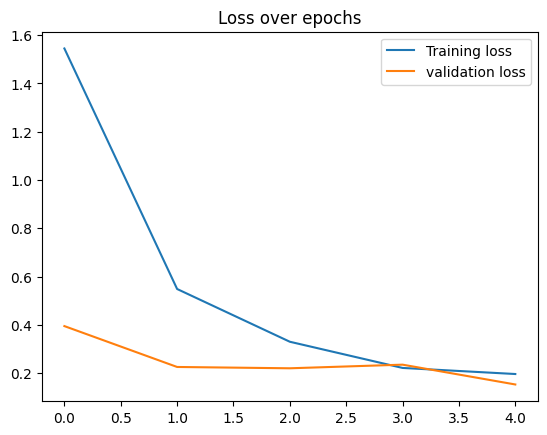

In [49]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(val_losses, label = 'validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

## Evaluating the Results

TypeError: the dtypes of parameters y (object) and height (float64) are incompatible

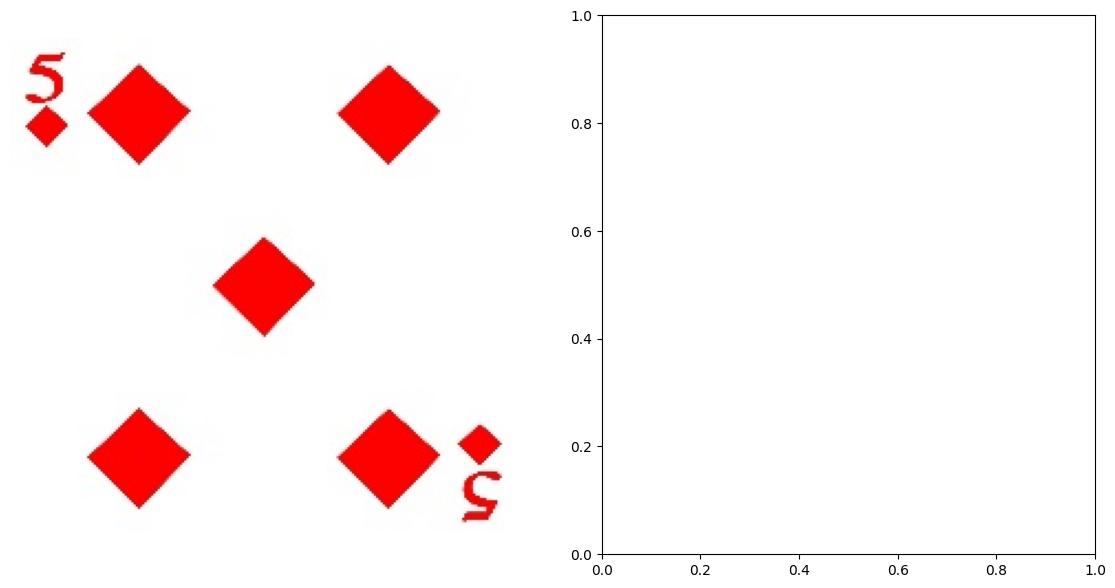

In [51]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()


# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()
    
    
# Example usage
test_image = "/kaggle/input/cards-image-datasetclassification/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)

TypeError: the dtypes of parameters y (object) and height (float64) are incompatible

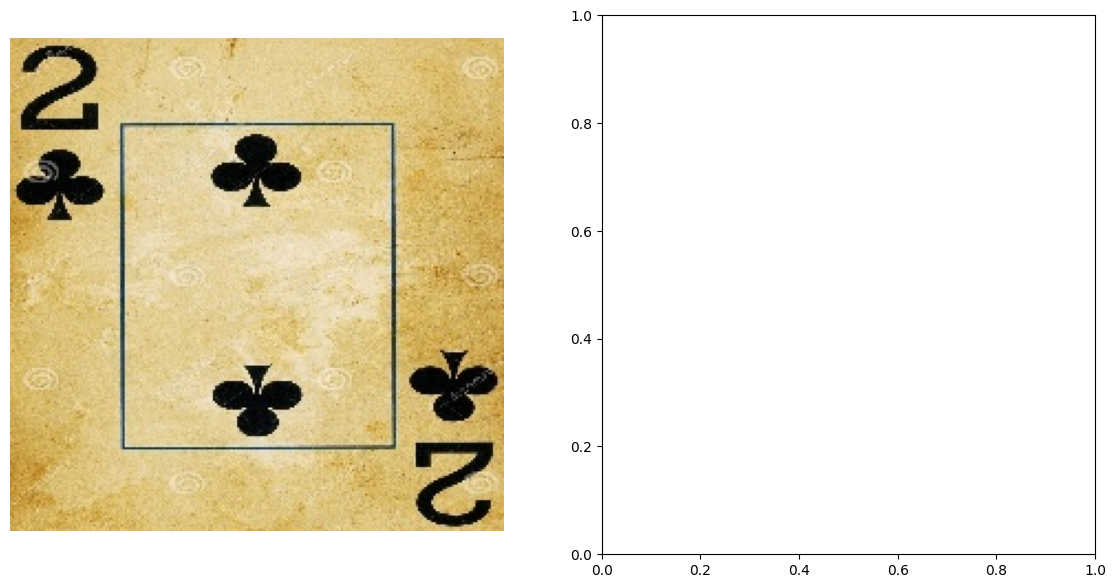

In [52]:
from glob import glob
test_images = glob('../input/cards-image-datasetclassification/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)

In [58]:
# Example usage
test_image = "/kaggle/input/cards-image-datasetclassification/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)
probabilities


array([5.2870369e-10, 2.0485052e-08, 1.4412229e-09, 2.4832741e-10,
       3.3244335e-10, 1.6294715e-07, 1.5206046e-08, 2.7805214e-09,
       4.9573284e-08, 9.9937743e-01, 5.5481686e-04, 1.6075206e-06,
       2.8554321e-09, 7.0233477e-07, 5.9244041e-08, 1.3861321e-09,
       2.2270044e-13, 1.8528716e-07, 4.4676502e-09, 2.5081220e-10,
       1.4474259e-10, 9.4915421e-12, 5.0276984e-08, 1.8106792e-10,
       2.3160958e-11, 6.2555593e-11, 2.8907419e-07, 5.5825738e-10,
       3.6474451e-10, 2.8829023e-10, 1.0037251e-08, 1.5789529e-10,
       1.5644983e-09, 1.8769004e-09, 6.0758710e-05, 6.3574369e-08,
       2.3589800e-08, 1.2264441e-09, 3.0821350e-06, 8.1361250e-08,
       1.0391481e-08, 2.1006329e-10, 1.1121933e-07, 2.6781459e-09,
       1.4889249e-09, 8.8971547e-10, 4.9214458e-07, 1.3194490e-09,
       5.2797416e-10, 9.6795211e-12, 1.6029142e-08, 1.0987776e-09,
       7.4503881e-10], dtype=float32)

## Accuracy of the model

In [59]:
from sklearn.metrics import accuracy_score

def compute_accuracy_sklearn(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

# Usage
accuracy = compute_accuracy_sklearn(model, test_loader, device)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.95
